In [15]:
import ROOT
from sys import exit
import numpy as np
from numpy.testing import assert_array_equal
from nose.tools import (raises, assert_raises, assert_true,
                        assert_equal, assert_almost_equal)
import root_numpy as rnp
import pandas as pd
from pandas.plotting import scatter_matrix
ROOT.ROOT.EnableImplicitMT()

from sklearn import preprocessing

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

#look at data loaded
import matplotlib.pyplot as plt
import plotly.express as px

#read in key parameters from root file
#data = rnp.root2array("../data_02/mlTree.root","mltree",branches=['x','e1','e2','e3','e12','e13',
#                                                                   'e23','e123','recoilID'])

data_in = rnp.root2array("../data/pyTreeAverageAverageJ_train.root","pytree",
                         branches=['e0','e1','e2','e3','e4','e5','e6','x','m','dt','gmult','ge','gid','glabel'])
assert_equal(data_in.dtype.names, ('e0','e1','e2','e3','e4','e5','e6','x','m','dt','gmult','ge','gid','glabel'))
print(data_in.dtype)
num_data_columns=14.0
#convert to pandas
df = pd.DataFrame(data=data_in)
print(df)
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_scaled = min_max_scaler.fit_transform(x)
res_df = pd.DataFrame(x_scaled)
df_g1293 = df[(df['ge'] > 1285) & (df['ge'] < 1298)]
print(df_g1293.size/num_data_columns)
#data to torch tensor
X = torch.from_numpy(res_df.values).float().to(torch.device('cpu'))
#print(X)

[('e0', '<f4'), ('e1', '<f4'), ('e2', '<f4'), ('e3', '<f4'), ('e4', '<f4'), ('e5', '<f4'), ('e6', '<f4'), ('x', '<f4'), ('m', '<f4'), ('dt', '<f4'), ('gmult', '<i4'), ('ge', '<f4'), ('gid', '<f4'), ('glabel', '<f4')]
                e0           e1           e2           e3           e4  \
0      2127.264893  1312.559204  1777.864014  3439.824219  3905.128906   
1      2077.941895  1270.559204  1880.864014  3348.500977  3958.805908   
2      1747.946655   882.959229  1158.864014  2630.905762  2906.810547   
3      1493.110596   813.359192   833.864014  2306.469727  2326.974609   
4      1533.038818   774.959229   872.864014  2307.998047  2405.902832   
...            ...          ...          ...          ...          ...   
85439  1889.103638  1074.083496  1416.869019  2963.187012  3305.972656   
85440  1747.879639   925.123474  1218.869019  2673.003174  2966.748535   
85441  1599.983643   875.913452  1051.869019  2475.896973  2651.852539   
85442  1941.367676  1124.623413  1503.86901

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 20)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(20, 10)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(10, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
net = Net()

In [16]:
#Model D with AverageFatD_train data (mar31 9pm)
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(11, 40)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(40, 20)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(20, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
net = Net()

In [17]:
#print(net.parameters)
#print(net.state_dict())
save_path="./model_saves/model_H.pt"
net = torch.load(save_path)
net.eval()

/usr/local/lib/python3.7/site-packages/torch/serialization.py:559: UserWarning:

Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.



Net(
  (fc1): Linear(in_features=11, out_features=40, bias=True)
  (relu1): ReLU()
  (dout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (prelu): PReLU(num_parameters=1)
  (out): Linear(in_features=20, out_features=1, bias=True)
  (out_act): Sigmoid()
)

In [18]:
with torch.no_grad():
    result = net(X[0:6000000,0:11])
    #result = torch.round(result)
#plt.plot(result.data)
print(torch.max(result))
print(torch.min(result))
torch.histc(result)
#print(result.data)

df_F = pd.DataFrame(data=result.numpy())
#print(df_F)
df_F.columns = ["A"]
result_df = pd.concat([df, df_F], axis=1)

#fig = px.histogram(df_F,x="A",nbins=100)
#fig.update_xaxes(range=[0.0,1.0])
#fig.show()

tensor(0.9919)
tensor(0.0013)


In [19]:

#result_df.to_csv("output/pyTreeAverageFatH_tester.csv",sep=" ",header=False)





In [20]:
#print("cut tot% g1293 % g1535 % g383 % g639 % g1190 % g2044 % g2279 % g2978 % g3142 % g1848 %")
total = []
ml_return = []
g1293 = [] #1280-1300
g1535 = [] #1525-1545
g848 = [] #840-860
g383 = [] #380-390
g292 = [] #285-298
g639 = [] # 630-645
g1190 = [] #1180-1200
g2044 = [] #2035-2055
g2279 = [] #2260-2290
g2978 = [] #2960-2990
g3142 = [] #3130-3160
g1848 = [] #1835-1855
g1430 = [] #1420-1440
g2378 = [] #2370-2385
g136 = [] #130-145
g170 = [] #165-175
g1293t = [] #1280-1300
g1535t = [] #1525-1545
g848t = [] #840-860
g383t = [] #380-390
g292t = [] #285-298
g639t = [] # 630-645
g1190t = [] #1180-1200
g2044t = [] #2035-2055
g2279t = [] #2260-2290
g2978t = [] #2960-2990
g3142t = [] #3130-3160
g1848t = [] #1835-1855
g1430t = [] #1420-1440
g2378t = [] #2370-2385
g136t = [] #130-145
g170t = [] #165-175
ratio1 = []
ratio2 = []
ratio3 = []
for cut_val in range(50):
    cut_low=cut_val*0.02
    ml_return.append(cut_low)
    #total count stuff
    total_counts = result_df[(result_df['A'] > 0)]
    total_counts_frac = result_df[(result_df['A'] > cut_low)]
    if (total_counts.size>0):
        total.append(total_counts_frac.size/total_counts.size)
    #g3142 stuff
    g3142_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >3130) 
                   & (result_df['ge'] < 3160) ]
    g3142_tot = result_df[(result_df['ge'] >3130) 
                   & (result_df['ge'] < 3160) ]
    if (g3142_tot.size>0):
        g3142.append(g3142_counts.size/g3142_tot.size)
    g3142t.append(g3142_counts.size/15)

    #g2978 stuff
    g2978_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2960) 
                   & (result_df['ge'] < 2990) ]
    g2978_tot = result_df[(result_df['ge'] >2960) 
                   & (result_df['ge'] < 2990) ]
    if (g2978_tot.size>0):
        g2978.append(g2978_counts.size/g2978_tot.size)
    g2978t.append(g2978_counts.size/15)
    #g2279 stuff
    g2279_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2260) 
                   & (result_df['ge'] < 2290) ]
    g2279_tot = result_df[(result_df['ge'] >2260) 
                   & (result_df['ge'] < 2290) ]
    if (g2279_tot.size>0):
        g2279.append(g2279_counts.size/g2279_tot.size)
    g2279t.append(g2279_counts.size/15)
    #g2044 stuff
    g2044_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2035) 
                   & (result_df['ge'] < 2055) ]
    g2044_tot = result_df[(result_df['ge'] >2035) 
                   & (result_df['ge'] < 2055) ]
    if (g2044_tot.size>0):
        g2044.append(g2044_counts.size/g2044_tot.size)
    g2044t.append(g2044_counts.size/15)
    #g1293 stuff
    g1293_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1280) 
                   & (result_df['ge'] < 1300) ]
    g1293_tot = result_df[(result_df['ge'] >1280) 
                   & (result_df['ge'] < 1300) ]
    if (g1293_tot.size>0):
        g1293.append(g1293_counts.size/g1293_tot.size)
    g1293t.append(g1293_counts.size/15)
    #g1535 stuff #1525-1545
    g1535_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1525) 
                   & (result_df['ge'] < 1545) ]
    g1535_tot = result_df[(result_df['ge'] >1525) 
                   & (result_df['ge'] < 1545) ]
    if (g1535_tot.size>0):
        g1535.append(g1535_counts.size/g1535_tot.size)
    #g383 stuff
    g383_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >380) 
                   & (result_df['ge'] < 390) ]
    g383_tot = result_df[(result_df['ge'] >380) 
                   & (result_df['ge'] < 390) ]
    if (g383_tot.size>0):
        g383.append(g383_counts.size/g383_tot.size)
    #g292 - 285-298
    g292_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >285) 
                       & (result_df['ge'] < 298) ]
    g292_tot = result_df[(result_df['ge'] >285) 
                       & (result_df['ge'] < 298) ]
    if (g292_tot.size>0):
        g292.append(g292_counts.size/g292_tot.size)
    #g639 - 630-645
    g639_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >630) 
                       & (result_df['ge'] < 645) ]
    g639_tot = result_df[(result_df['ge'] >630) 
                       & (result_df['ge'] < 645) ]
    if (g639_tot.size>0):
        g639.append(g639_counts.size/g639_tot.size)
    #g1190
    g1190_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1170) 
                       & (result_df['ge'] < 1210) ]
    g1190_tot = result_df[(result_df['ge'] >1170) 
                       & (result_df['ge'] < 1210) ]
    if (g1190_tot.size>0):
        g1190.append(g1190_counts.size/g1190_tot.size)
    g1190t.append(g1190_counts.size/15)
    #g1848
    g1848_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1830) 
                       & (result_df['ge'] < 1850) ]
    g1848_tot = result_df[(result_df['ge'] >1830) 
                       & (result_df['ge'] < 1850) ]
    if (g1848_tot.size>0):
        g1848.append(g1848_counts.size/g1848_tot.size)
    #g1848
    g1430_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >1420) 
                       & (result_df['ge'] < 1440) ]
    g1430_tot = result_df[(result_df['ge'] >1420) 
                       & (result_df['ge'] < 1440) ]
    if (g1430_tot.size>0):
        g1430.append(g1430_counts.size/g1430_tot.size)
    #g2378
    g2378_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >2370) 
                       & (result_df['ge'] < 2390) ]
    g2378_tot = result_df[(result_df['ge'] >2370) 
                       & (result_df['ge'] < 2390) ]
    if (g2378_tot.size>0):
        g2378.append(g2378_counts.size/g2378_tot.size)
    #g136
    g136_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >130) 
                       & (result_df['ge'] < 145) ]
    g136_tot = result_df[(result_df['ge'] >130) 
                       & (result_df['ge'] < 145) ]
    if (g136_tot.size>0):
        g136.append(g136_counts.size/g136_tot.size)
    #g170
    g170_counts = result_df[(result_df['A'] > cut_low) & (result_df['ge'] >160) 
                       & (result_df['ge'] < 185) ]
    g170_tot = result_df[(result_df['ge'] >160) 
                       & (result_df['ge'] < 185) ]
    if (g170_tot.size>0):
        g170.append(g170_counts.size/g170_tot.size)
    ratio1.append(g1190_counts.size/g1293_counts.size)
    ratio2.append(g639_counts.size/g383_counts.size)
    ratio3.append(g3142_counts.size/g1535_counts.size)

df_ratio=pd.DataFrame(ratio1, columns=['1190/1293'])
df_ratio2=pd.DataFrame(ratio2, columns=['639/383'])
df_ratio3=pd.DataFrame(ratio3, columns=['3142/1535'])

df_ratio=pd.concat([df_ratio, df_ratio2], axis=1)
df_ratio=pd.concat([df_ratio, df_ratio3], axis=1)

df_frac=pd.DataFrame(ml_return, columns=['ml_return'])
df_tot=pd.DataFrame(ml_return, columns=['ml_return'])

df1293t=pd.DataFrame(g1293t, columns=['g1293t'])
df1190t=pd.DataFrame(g1190t, columns=['g1190t'])

df_tot=pd.concat([df_tot, df1293t], axis=1)
df_tot=pd.concat([df_tot, df1190t], axis=1)

print(df_tot)
df1293=pd.DataFrame(g1293, columns=['1293'])
df1535=pd.DataFrame(g1535, columns=['1535'])
df383=pd.DataFrame(g383, columns=['383'])
df639=pd.DataFrame(g639, columns=['639'])
df1190=pd.DataFrame(g1190, columns=['1190'])
df2044=pd.DataFrame(g2044, columns=['2044'])
df2279=pd.DataFrame(g2279, columns=['2279'])
df2978=pd.DataFrame(g2978, columns=['2978'])
df3142=pd.DataFrame(g3142, columns=['3142'])
df1848=pd.DataFrame(g1848, columns=['1848'])
df1430=pd.DataFrame(g1430, columns=['1430'])
df2378=pd.DataFrame(g2378, columns=['2378'])
df136=pd.DataFrame(g136, columns=['136'])
df170=pd.DataFrame(g170, columns=['170'])

df_frac = pd.concat([df_frac, df1293], axis=1)
df_frac = pd.concat([df_frac, df1535], axis=1)
df_frac = pd.concat([df_frac, df383], axis=1)
df_frac = pd.concat([df_frac, df639], axis=1)
df_frac = pd.concat([df_frac, df1190], axis=1)
df_frac = pd.concat([df_frac, df2044], axis=1)
df_frac = pd.concat([df_frac, df2279], axis=1)
df_frac = pd.concat([df_frac, df2978], axis=1)
df_frac = pd.concat([df_frac, df3142], axis=1)
df_frac = pd.concat([df_frac, df1848], axis=1)
df_frac = pd.concat([df_frac, df1430], axis=1)
df_frac = pd.concat([df_frac, df2378], axis=1)
df_frac = pd.concat([df_frac, df136], axis=1)
df_frac = pd.concat([df_frac, df170], axis=1)

df_plot = df_frac.set_index('ml_return').T
#print(df_frac)
print(df_ratio)

    ml_return   g1293t  g1190t
0        0.00  11076.0  3867.0
1        0.02  11076.0  3867.0
2        0.04  11076.0  3867.0
3        0.06  11076.0  3867.0
4        0.08  11076.0  3867.0
5        0.10  11076.0  3867.0
6        0.12  11076.0  3867.0
7        0.14  11076.0  3867.0
8        0.16  11076.0  3867.0
9        0.18  11076.0  3867.0
10       0.20  11072.0  3866.0
11       0.22  11071.0  3866.0
12       0.24  11064.0  3865.0
13       0.26  11032.0  3854.0
14       0.28  10986.0  3839.0
15       0.30  10877.0  3805.0
16       0.32  10705.0  3759.0
17       0.34  10490.0  3703.0
18       0.36  10219.0  3632.0
19       0.38   9955.0  3524.0
20       0.40   9677.0  3422.0
21       0.42   9434.0  3307.0
22       0.44   9233.0  3171.0
23       0.46   9060.0  3021.0
24       0.48   8858.0  2844.0
25       0.50   8588.0  2504.0
26       0.52   8274.0  2102.0
27       0.54   7921.0  1634.0
28       0.56   7625.0  1297.0
29       0.58   7362.0  1044.0
30       0.60   7187.0   869.0
31      

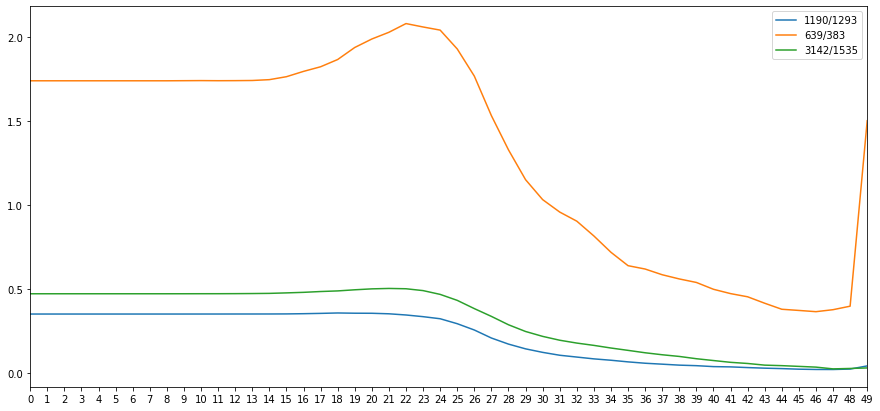

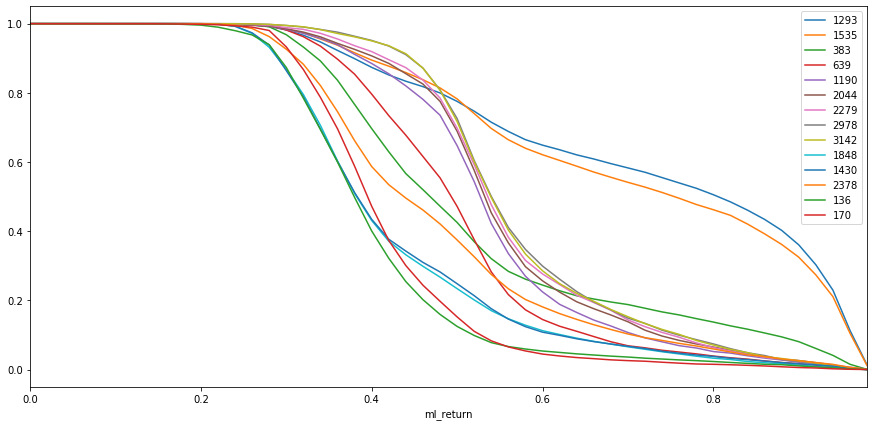

In [21]:
Headers = df_frac.columns.values.tolist()
import plotly.graph_objs as go
from plotly import tools

df_ratio.plot(figsize=(15,7), xticks=range(0, 50)).legend(bbox_to_anchor=(1, 1))
df_frac.plot.line(x='ml_return',figsize=(15,7)).legend(bbox_to_anchor=(1, 1))


s38_low=0.75
other_high=0.3
num_data_columns=15
s38 = result_df[(result_df['A'] > s38_low) & (result_df['A'] < 1)]
cl38 = result_df[(result_df['A'] < other_high) & (result_df['A'] < 1)]
misc = result_df[(result_df['A'] > other_high) & (result_df['A'] < s38_low)]
g1293a = result_df[(result_df['A'] > s38_low) & (result_df['ge'] >1285) & (result_df['ge'] < 1298)]
g1293_s38 = g1293a.size/num_data_columns
g1293b = result_df[(result_df['A'] < other_high) & (result_df['ge'] >1285) & (result_df['ge'] < 1298)]
g1293_cl38 = g1293b.size/num_data_columns
g1293c = result_df[(result_df['A'] > other_high) & (result_df['A'] < s38_low) & 
                   (result_df['ge'] >1285) & (result_df['ge'] < 1298)]
g1293_misc = g1293c.size/num_data_columns
#print(s38.size/num_data_columns)
print("Total 1293 gamma rays for 38S: %d" 
      % (g1293_s38))
plt.figure(figsize=(10,4))
fig = px.histogram(s38, x="ge", nbins=10000, color = "glabel")
fig.update_xaxes(range=[100, 3100])
fig.show()

plt.figure(figsize=(10,4))
fig = px.histogram(cl38, x="ge", nbins=10000, color = "glabel")
fig.update_xaxes(range=[100, 3100])
fig.show()

plt.figure(figsize=(10,4))
fig = px.histogram(misc, x="ge", nbins=10000, color = "glabel")
fig.update_xaxes(range=[100, 3100])
fig.show()
